# Introduction

Make sure to have the data locally locally saved as `/data`.

In [52]:
# Import libraries
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

## Loading Data

In [53]:
"""
Save the data directories into variables
"""

main_direc = os.getcwd()
images_dir = os.path.join(main_direc, 'data/images/images')

# csv location
artist_csv_loc = os.path.join(main_direc, 'data/artists.csv')

In [54]:
"""
Set hyperparams for images
"""

IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 64
NUM_ARTISTS = 10 # this is 11 to get to 10 classes, can be changed...

In [55]:
"""
Collect the top 10 artists, sort data
"""

# Collecting Needed Images
artists = pd.read_csv(artist_csv_loc)

# Creating a dataframe with the top 10 artists by number of paintings
artists_sort = artists.sort_values(by=['paintings'], ascending=False)

# add 1 to reach the first 10 classes
artists_top = artists_sort.head(NUM_ARTISTS + 1)

# Images
artists_dir = os.listdir(images_dir) # Files are named after each artists

# Images DataFrame
artists_top_name = artists_top['name'].str.replace(' ', '_').values

images_df = pd.DataFrame()
for name in artists_top_name:
    images_df = pd.concat([images_df, pd.DataFrame(data={'Path': glob.glob('data/images/images/' + name + '/*'), 'Name': name})], ignore_index=True)

train_df = images_df.sample(frac=0.8, random_state=200)
test_df = images_df.drop(train_df.index)

if K.backend.image_data_format() == 'channels_first':
    input_shape = (3, IMG_HEIGHT, IMG_WIDTH)
else:
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

### Visualizing Data

<BarContainer object of 11 artists>

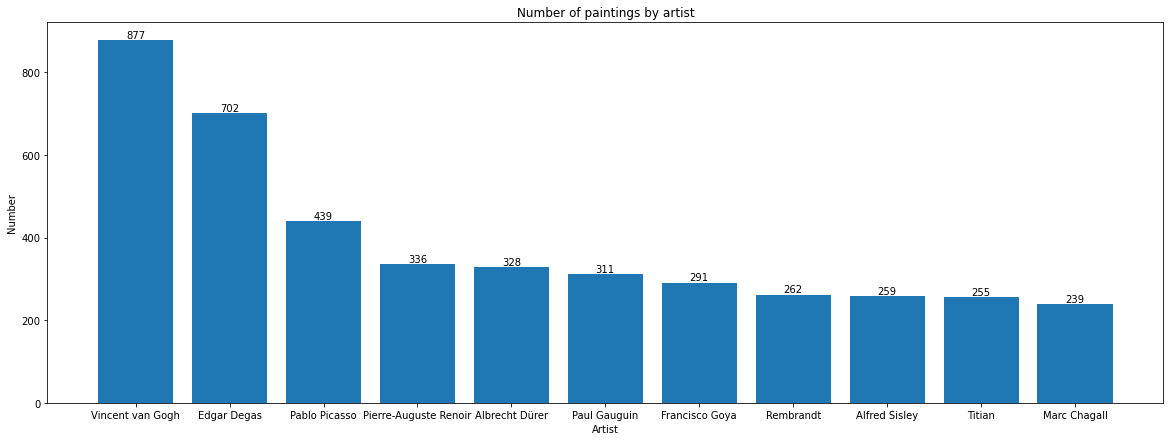

In [56]:
"""
    Print total number of paintings for each artist
"""

# plot to print out the number of paintings per artist
plt.figure(figsize=(20, 7)) # need to increase width to space out labels on bottom

plt.title("Number of paintings by artist")
plt.ylabel("Number")
plt.xlabel("Artist")

# add labels onto the bar itself
painting_num = list(artists_top['paintings'])
for i in range(len(painting_num)): 
    plt.text(x=i, y=painting_num[i], s=painting_num[i], ha='center', va='bottom')

# plot the chart
plt.bar(artists_top['name'], artists_top['paintings'])


In [ ]:
"""
Build generators
"""

train_generator = ImageDataGenerator(rescale=1.0 / 255,
                                    rotation_range=20,
                                    zoom_range=0.05,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.05,
                                    horizontal_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.15
                                    )

test_generator = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_generator.flow_from_dataframe(
    train_df,
    shuffle=True,
    x_col='Path',
    y_col='Name',
    class_mode='categorical',
    subset="training",
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=42
)

valid_gen = train_generator.flow_from_dataframe(
    train_df,
    subset="validation",
    shuffle=True,
    x_col='Path',
    y_col='Name',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=42
)

test_gen = test_generator.flow_from_dataframe(
    test_df,
    x_col='Path',
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

# Set the amount of steps for training, validation, and testing data
# based on the batch size
steps_train = train_gen.n//train_gen.batch_size
steps_valid = valid_gen.n//valid_gen.batch_size
steps_test = test_gen.n//test_gen.batch_size

## Baseline Model
The following model is a very simple convolutional neural network. This was the
first model we tested, and used as a proof of concept early on in the project.

In [ ]:
"""
Hyperparameters
"""

N_EPOCHS = 10
LEARNING_RATE = 0.001 # 0.001 is the default for Adam set by TensorFlow
OPTIMIZER = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FUNCTION = tf.losses.CategoricalCrossentropy(from_logits=False)

In [ ]:
"""
This block contains the code for the model itself
"""

base_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(NUM_ARTISTS)
])

# compile model
base_model.compile(
  optimizer=OPTIMIZER,
  loss=LOSS_FUNCTION,
  metrics=['accuracy']
)


In [ ]:
"""
Train the model
"""

# create a checkpoint for the model
checkpt = ModelCheckpoint(filepath='baseline_model.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Fit the model
base_model.fit_generator(
    generator = train_gen,
    steps_per_epoch=steps_train,
    validation_data = valid_gen,
    validation_steps = steps_valid,
    verbose=1,
    epochs=N_EPOCHS,
    callbacks=[checkpt, early_stop]
)

### Metrics for the baseline model

In [ ]:
"""
Make predictions for the model
"""

# Load model weights
base_model.load_weights('baseline_model.hdf5')

# make predictions using the test set
predict = base_model.predict_generator(test_gen, steps=steps_test, verbose=1)

# collect the actual index of the predicted class
predicted_class = np.argmax(predict, axis=1)

In [ ]:
"""
Produce result metrics
"""

# collect the actual classes of the predictions
r = dict(train_gen.class_indices.items())
y_true = test_df['Name']
y_true = [r[k] for k in y_true]

# create confusion matrix
cm = confusion_matrix(y_true, predicted_class)
sns.heatmap(cm, annot=True)

# print classification report
print(classification_report(y_true, predicted_class))